In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean

# for maps, import...
import cartopy as cp
# CRS holds the various projections
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

# to read the satellite data, import...
import netCDF4 as nc
from netCDF4 import Dataset as NetCDFFile

# for binning data
import scipy.stats as ss
import scipy

import math

In [2]:
# import data for figures

# READ IN HIGH-RES COASTLINE FROM GSHHS (l1)
shp = shapereader.Reader('C:/Users/corda/Dropbox/Resources/Shoreline/GSHHS_shp/h/GSHHS_h_L1.shp')

# READ IN DATA FILE
infile = '..\Data\ETSP15_Nuptake_20200128MRM.csv'
df = pd.read_csv(infile, sep=',')

df.columns

Index(['Sta', 'Lat', 'Lon', 'zPP_mmolC_m2_d', 'zPP_mgC_m2_d', 'zChl_mg_m2',
       'PPindex_mgC_mgChl_d', 'zPN_mgN_m2', 'zPC_mgC_m2', 'PCtoPN', 'CtoChl',
       'C_turntime_d', 'GrowthRate_d', 'SfcNO3_uM', 'SfcNO3up_nmolN_L_h',
       'SfcNO2up_nmolN_L_h', 'SfcNH4up_nmolN_L_h', 'SfcUreaup_nmolN_L_h',
       'SfcSumNup_nmolN_L_h', 'SfcPP_umolC_L_d', 'SfcPPstdev_umolC_L_d',
       'CtoNup', 'SfcChl_ug_L', 'SfcTemp_C'],
      dtype='object')

In [18]:
# read in bathymetry file (netCDF)

# BATHYMETRY CITATION:
# Amante, C. and B.W. Eakins, 2009. ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. 
# NOAA Technical Memorandum NESDIS NGDC-24. National Geophysical Data Center, NOAA. doi:10.7289/V5C8276M [2019-06-21].

infile = 'C:/Users/corda/Dropbox/Resources/etopo1_bedrock.nc'
bathy_df = nc.Dataset(infile)
blat = bathy_df.variables['lat'][:]
blon = bathy_df.variables['lon'][:]
bathy = bathy_df.variables['Band1'][:]

# create an array for bathy data; if you don't do this, you'll get error:  "x and y must be same length"
bx, by = np.meshgrid(blon, blat)

bathy_df.close()

In [38]:
# define station numbers
number = np.arange(1,len(df.Lat) + 1, 1)
stn_label = ["  " + str(i) for i in number]

# set map extent
extent = [-85, -72, -21, -10]

# create a function to populate a cartopy map
def make_map2(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(subplot_kw=dict(projection=projection),figsize = (6,5), dpi = 300)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, zorder = 0, linestyle='--') # increase alpha to increase gridliner visibility
    gl.xlabels_top = gl.ylabels_right = False
    ax.text(-0.15, 0.41, 'Latitude', va = 'bottom', ha = 'center', transform = ax.transAxes, rotation = -270)
    ax.text(0.5, -0.15, 'Longitude', va = 'bottom', ha = 'center', transform = ax.transAxes)
    plt.gcf().subplots_adjust(left = 0.1, bottom = 0.15, top = 0.92, right = 0.98)
    
    # HIGH-RES COASTLINE
    ax.add_geometries(shp.geometries(),ccrs.PlateCarree(), facecolor='lightgrey', edgecolor='grey', linewidth = 1, zorder = 0)

    # ALTERNATE LOW-RES COASTLINE
    # ax.coastlines(resolution = '10m', zorder = -1) # this uses the preloaded coastlines
    # ax.add_feature(cp.feature.LAND, facecolor = 'lightgrey', zorder = -1) # this is cruder even than the coastline

    ax.plot(df.Lon, df.Lat,'ok', markersize = '3', mfc = 'white')
    for i,xy in enumerate(zip(df.Lon,df.Lat)):
        ax.annotate(stn_label[i], xy, color = 'black', zorder = 101)

    ax.contour(bx, by, bathy, [-1000, -500, -200], colors = 'grey', transform = ccrs.PlateCarree(), zorder = 1, linewidths = 1, linestyles = '-')
    
    
    return fig, ax

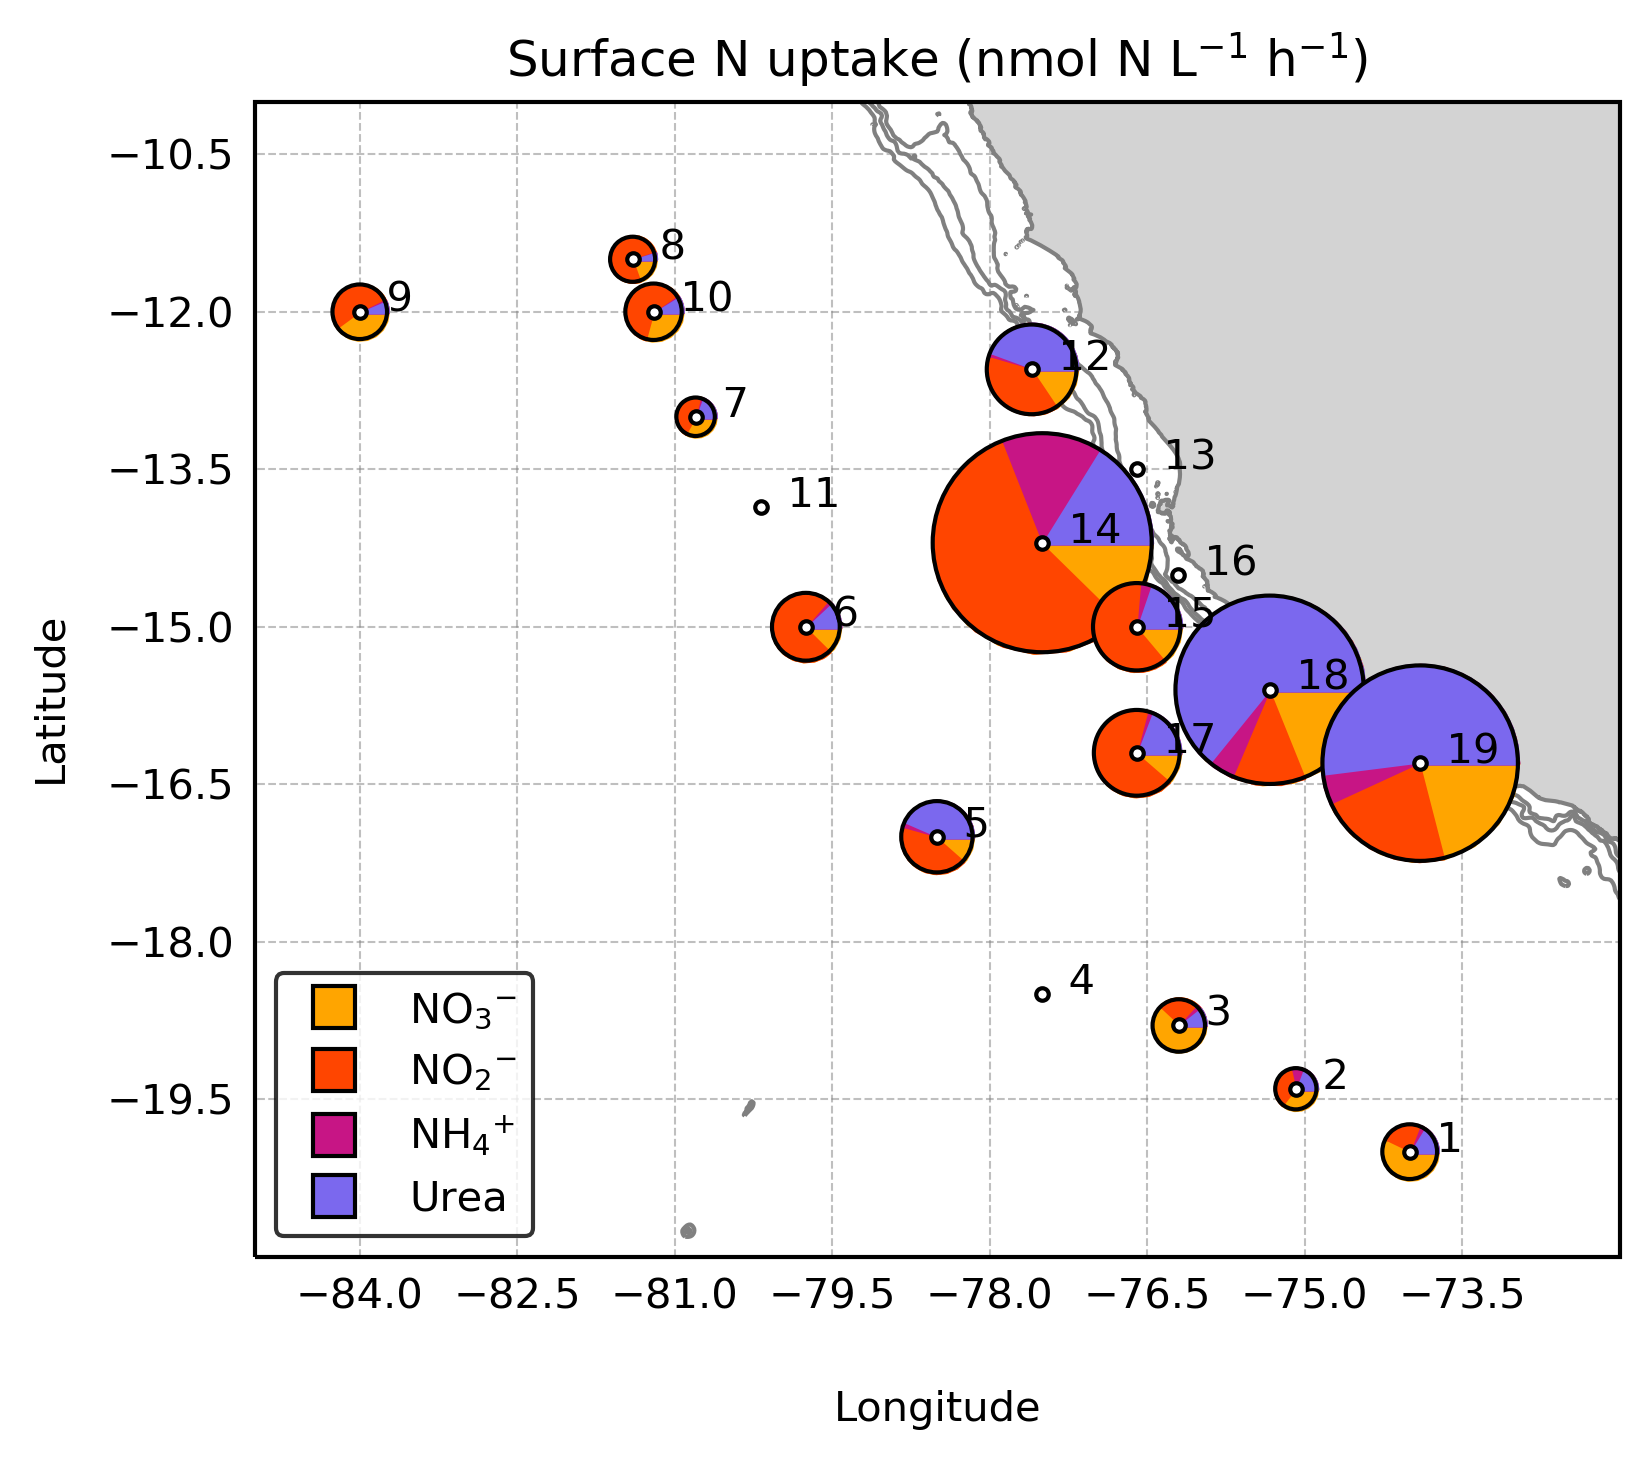

In [39]:
# no uptake rates for stas 4 or 11
# no NO3 uptake for stats 13 and 16

fig, ax = make_map2(projection=ccrs.PlateCarree())
ax.set_extent(extent)

i = 1
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 2
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 3
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 5
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 6
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 7
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 8
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 9
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)

############
i = 10
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 11
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)

############
i = 12
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)

############
i = 14
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)



############
i = 15
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 17
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 18
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)


############
i = 19
sta = df[df.Sta==i]
    
r1 = (sta.SfcNO3up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h).item()
r2 = (r1+(sta.SfcNO2up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r3 = (r2+(sta.SfcNH4up_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()
r4 = (r3+(sta.SfcUreaup_nmolN_L_h/sta.SfcSumNup_nmolN_L_h)).item()

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
xy1 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 20)).tolist()
xy2 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 20)).tolist()
xy3 = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 20)).tolist()
xy4 = np.column_stack([x, y])
    
lat = sta.Lat
lon = sta.Lon

ax.scatter(lon, lat, marker=(xy4, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orange')
ax.scatter(lon, lat, marker=(xy3, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='orangered')
ax.scatter(lon, lat, marker=(xy2, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumvioletred')
ax.scatter(lon, lat, marker=(xy1, 0),s=10*sta.SfcSumNup_nmolN_L_h, facecolor='mediumslateblue')
ax.scatter(lon, lat, edgecolor = 'k', facecolor = 'None', s=10*sta.SfcSumNup_nmolN_L_h)

line1, = ax.plot([1, 2, 3, 4], 's', mfc = 'orange', markeredgecolor = 'k', markersize = 10)
line2, = ax.plot([1, 2, 3, 4], 's', mfc = 'orangered', markeredgecolor = 'k',  markersize = 10)
line3, = ax.plot([1, 2, 3, 4], 's',mfc = 'mediumvioletred', markeredgecolor = 'k',  markersize = 10)
line4, = ax.plot([1, 2, 3, 4], 's',mfc = 'mediumslateblue', markeredgecolor = 'k',  markersize = 10)

ax.legend((line1, line2, line3, line4), ('NO$_{3}$$^{-}$', 'NO$_{2}$$^{-}$', 'NH$_{4}$$^{+}$', 'Urea'), edgecolor = 'k', loc = 'lower left')
ax.set_title('Surface N uptake (nmol N L$^{-1}$ h$^{-1}$)')

fig.savefig('..\Figures\ETSP15_PP_Nuptake.png')